## Objective

The primary objective of this project is to develop a robust classification model that will facilitate our client, AT&C, in accurately predicting the likelihood of customer churn. By leveraging technical and managerial insights gained from this model, our client will be empowered to proactively prevent customer churn, thereby ensuring the retention of both current and future customers. This strategic approach will not only drive revenue but also foster business growth for our client.

## Method of Analysis

Our core method of analysis is the Logistic Regression model. In general we sequence our implementation by leveraging the data mining process in the following order:

- Data preprocessing and Exploration: This involves the use of proper summary descriptive statistics and visualizations to understand the distribution of individual variables and relationship between two or more variables; duplicates analysis, outlier detection and or removal, missing values analysis, computation of new variables if necessary etc.
- Dimension reduction: selection of a subset of variables for model building.
- Data Partitioning: Creating Test and training dataset for K-fold Cross-Validation to evaluate model performance.
- Model Building: building the logistic regression classification model
- Model Evaluation: computation of metrics such as accuracy, sensitivity, specificity, precision etc.
- Model Deployment

## Data Description

Originated from India, the dataset contains 13000 rows of customer data across 14 variables. The dataset includes various demographic, location, and usage pattern variables for each customer, as well as a binary variable indicating whether the customer has churned or not. We describe the data variables below:

### Dependent Variable
- churn: Binary variable indicating whether the customer has churned or not (1 = churned, 0 = not churned).

### Independent Variables
- customer_id: Unique identifier for each customer.
- gender: The gender of the customer.
- telecom_partner: The telecom partner associated with the customer.
- age: The age of the customer.
- state: The Indian state in which the customer is located.
- city: The city in which the customer is located.
- pincode: The pincode of the customer's location.
- date_of_registration: The date on which the customer registered with the telecom partner.
- num_dependents: The number of dependents (e.g. children) the customer has.
- estimated_salary: The customer's estimated salary.
- calls_made: The number of calls made by the customer.
- sms_sent: The number of SMS messages sent by the customer.
- data_used: The amount of data used by the customer.

## Duplicate Analysis
In the next steps we implement analysis to solve for and manage any duplicates in the dataset

In [ ]:
# first we provision the required libraries to import our dataset below
import pyspark.pandas as ps
import numpy as np
data = ps.read_csv('s3://jiogboles3private/spark/new_telcom_churn.csv')
data.head(3)

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
5,application_1690843046081_0006,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   customer_id telecom_partner gender  age    state       city  pincode date_of_registration  num_dependents  estimated_salary  calls_made  sms_sent  data_used  churn
0       241859        Vodafone      M   58  Manipur  Bangalore   500407           2023-04-25               2             41014          61        45       9961      1
1        17876          Airtel      M   59  Mizoram     Mumbai   507230           2020-03-30               0             92175          92        12       1140      0
2        38273            BSNL      M   40    Bihar    Chennai   453495           2020-07-10               2            109436          82        19       -604      0
/mnt1/yarn/usercache/livy/appcache/application_1690843046081_0006/container_1690843046081_0006_01_000001/pyspark.zip/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.

In [ ]:
# Here we'd like to confirm the dimension i.e number of rows and columns in the dataset after dropping the customerID
# column
data.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(13000, 14)

As seen above, the code output confirms that we have 13000 observations and 14 variables

In [ ]:
# Next we run the code to check if there are any duplicates in the dataset
print(data.shape[0], data.to_spark().distinct().count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

13000 13000
/mnt1/yarn/usercache/livy/appcache/application_1690843046081_0006/container_1690843046081_0006_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

The output of the code above shows that all rows of the dataset are unique, as such there are not duplicates in the dataset.

## Missing Values Analysis

Next we check for missing or NA values in the dataset.

In [ ]:
#We run the following code to check if there are any empty or null values in the dataset
x = data.isna().sum(axis=1)
x[x >= 1].shape[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

The output of the code above returns a count of 0, implying that there are zero i.e no missing values in the dataset. Let's continue...

## Descriptive Statistics

Next we generate descriptive statistics below:

In [ ]:
#we run the code below to generate descriptive stats
descriptive_stats = data.describe()
descriptive_stats

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         customer_id          age        pincode        date_of_registration  num_dependents  estimated_salary    calls_made      sms_sent     data_used         churn
count   13000.000000  13000.00000   13000.000000                       13000     13000.00000      13000.000000  13000.000000  13000.000000  13000.000000  13000.000000
mean   122449.000000     46.00000  544247.000000  2021-09-04 08:49:35.261538         1.00000      85388.000000     48.000000     23.000000   5033.000000      0.000000
min         6.000000     18.00000  100020.000000         2020-01-01 00:00:00         0.00000      20004.000000    -10.000000     -5.000000   -955.000000      0.000000
25%     62181.000000     32.00000  319563.000000         2020-11-07 00:00:00         1.00000      53154.000000     24.000000     11.000000   2515.000000      0.000000
50%    122235.000000     46.00000  541106.000000         2021-09-03 00:00:00         2.00000      85251.000000     49.000000     24.000000   5043.000000      0.00000

Overall the descriptive statistics seem relatively regular with a few numbers appearing to standout as potential outliers liers or error imputs. for instance the minimum of the "calls_made" is a negative number which is not intuitive in this context. It's not possible to make negative amount of calls. we'll further investigate in the outlier section.

## Visualization
Next, we visualize the dataset for categorical and numerical variables.

### Numerical Variables Visualization
For numerical variables, we generate histograms using the process below:

In [ ]:
#first we write the code below that defines a function to plot histograms for each numerical variable in the dataset
def plot_hist(data, features, n_rows, n_cols):
    fig, ax = plt.subplots(n_rows, n_cols)
    fig.tight_layout(pad=2.2)
    for i in range(len(features)):
        data[features[i]].hist(ax=ax[i//n_cols, i%n_cols], title=features[i])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# The code below provisions the required libraries for visualization
import matplotlib.pyplot as plt
ps.set_option('plotting.backend', 'matplotlib')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

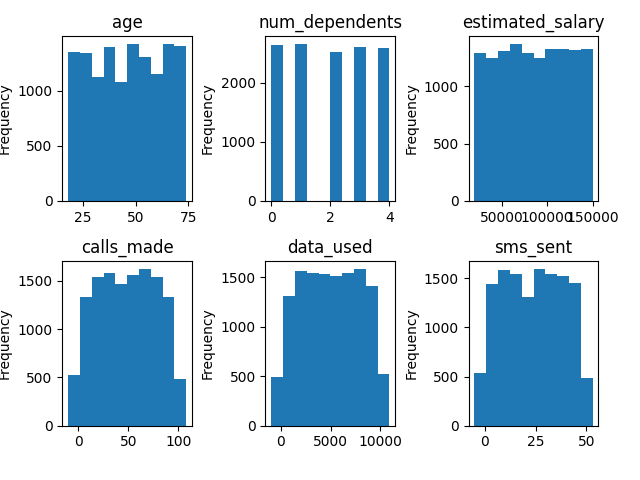

In [ ]:
# In the code below we create a variable list of the numerical variables and call the function on the list to create
# the histogram for each variable
features = ['age', 'num_dependents','estimated_salary','calls_made', 'data_used', 'sms_sent']
plot_hist(data=data, features=features, n_rows=2, n_cols=3)
%matplot plt

### Visualizing Interaction between numerical variables using Scatter Plots

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

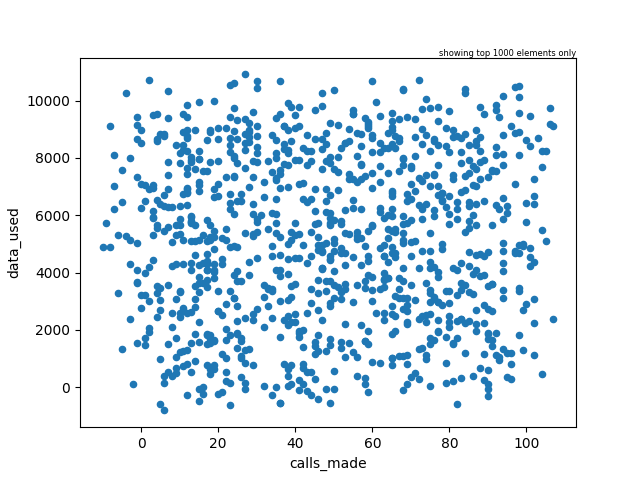

In [ ]:
#we run the code below to visualize the relationship between the no of calls made and amount of data used
data.plot.scatter('calls_made', 'data_used')
%matplot plt

The scatterplot above shows a clustering of certain points which might suggest that type of association between the variables. however the relationship as can be seen does not seeem to follow any positive or negative pattern

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

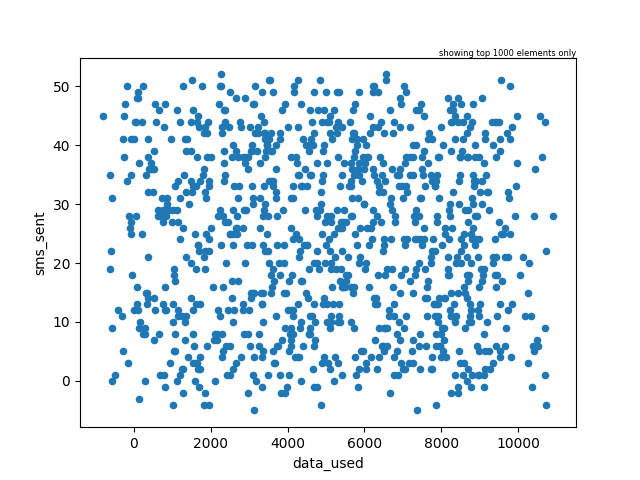

In [ ]:
#we run the code below to visualize the relationship between the no of data_used and sms_sent
data.plot.scatter('data_used', 'sms_sent')
%matplot plt

The scatterplot above shows a clustering of certain points which might suggest that type of association between the variables. however the relationship as can be seen does not seeem to follow any positive or negative pattern

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

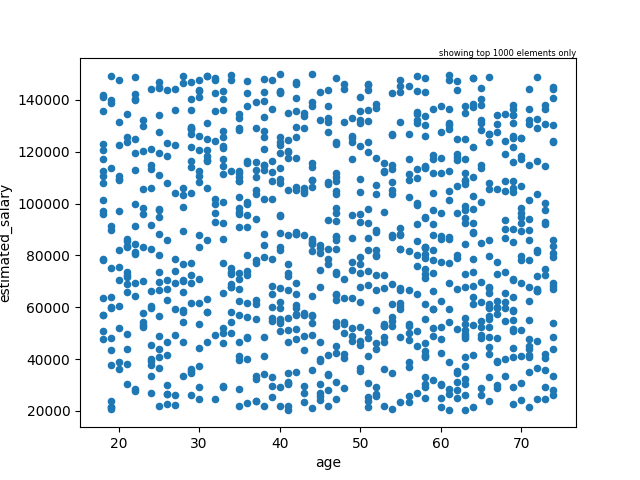

In [ ]:
#we run the code below to visualize the relationship between age and estimated salary
data.plot.scatter('age', 'estimated_salary')
%matplot plt

The scatterplot above shows a clustering of certain points which might suggest that type of association between the variables. however the relationship as can be seen does not seeem to follow any positive or negative pattern

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

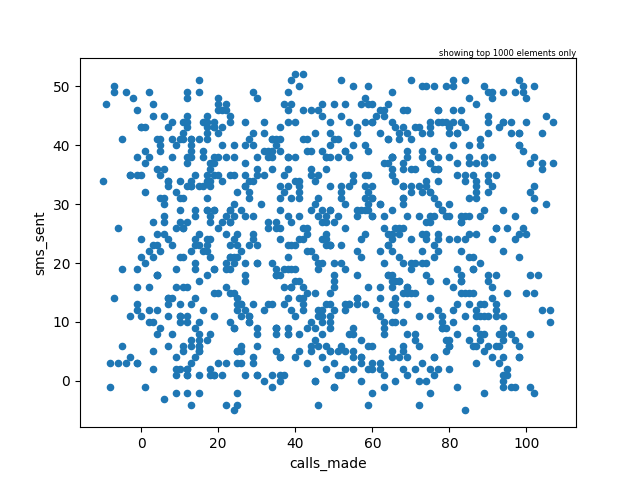

In [ ]:
#we run the code below to visualize the relationship between the no of calls made and sms_sent
data.plot.scatter('calls_made', 'sms_sent')
%matplot plt

The scatterplot above shows a clustering of certain points which might suggest that type of association between the variables. however the relationship as can be seen does not seeem to follow any positive or negative pattern

### Categorical Variables Visualization

Below we generate barcharts for the categorical variables using the process below

In [ ]:
#we write the code below to define a function to create bar charts of the categorical variables
import matplotlib.pyplot as plt

def plot_barchart(data, column):
    value_counts = data[column].value_counts()
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    ax = value_counts.plot(kind='bar')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(f'Bar Chart of {column}')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
    plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

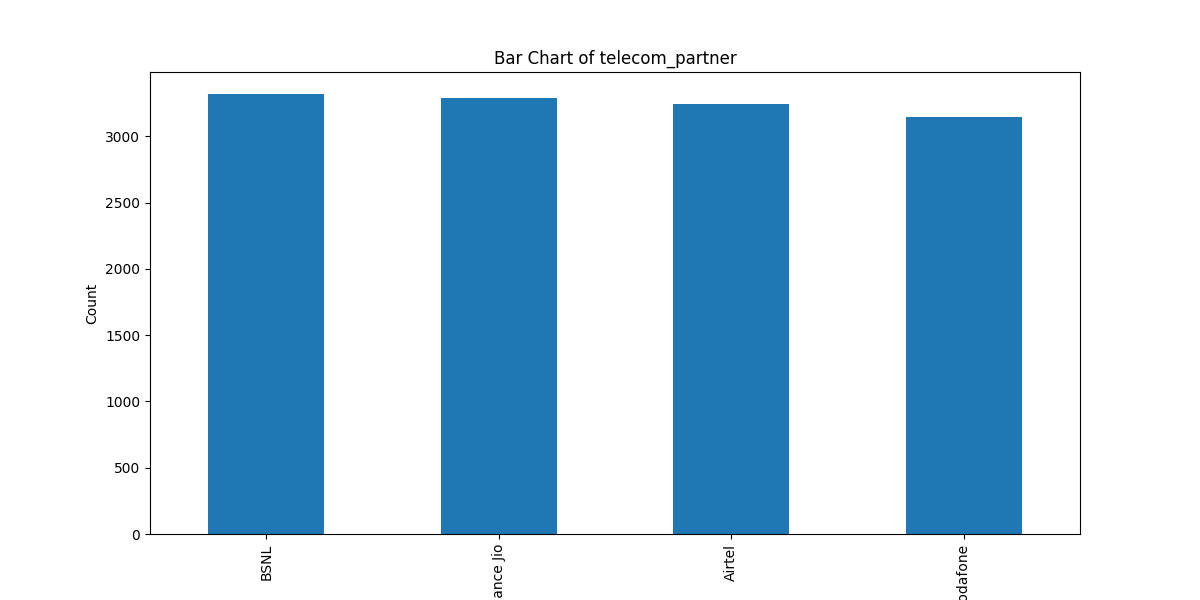

In [ ]:
#we run the code below to create a barchart for telecom_partner variable
plot_barchart(data, 'telecom_partner')
%matplot plt

The barchart above shows a more or less even distribution of the the four telecom partners

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

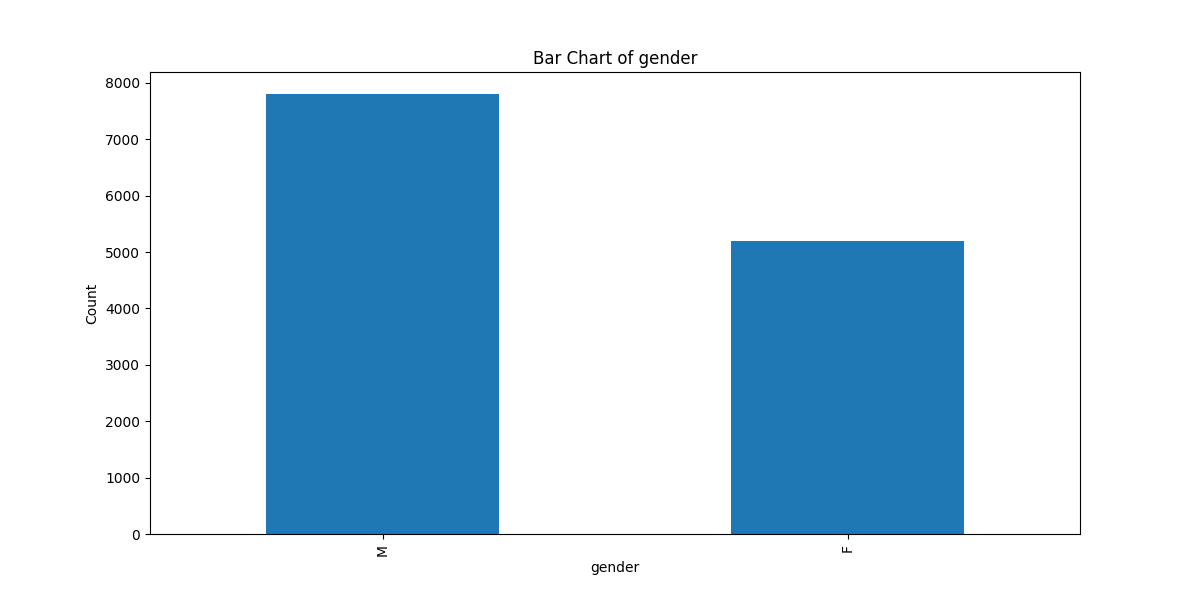

In [ ]:
#we run the code below to create a barchart for gender variable
plot_barchart(data, 'gender')
%matplot plt

The barchart shows that there are more male than female represented in the dataset

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

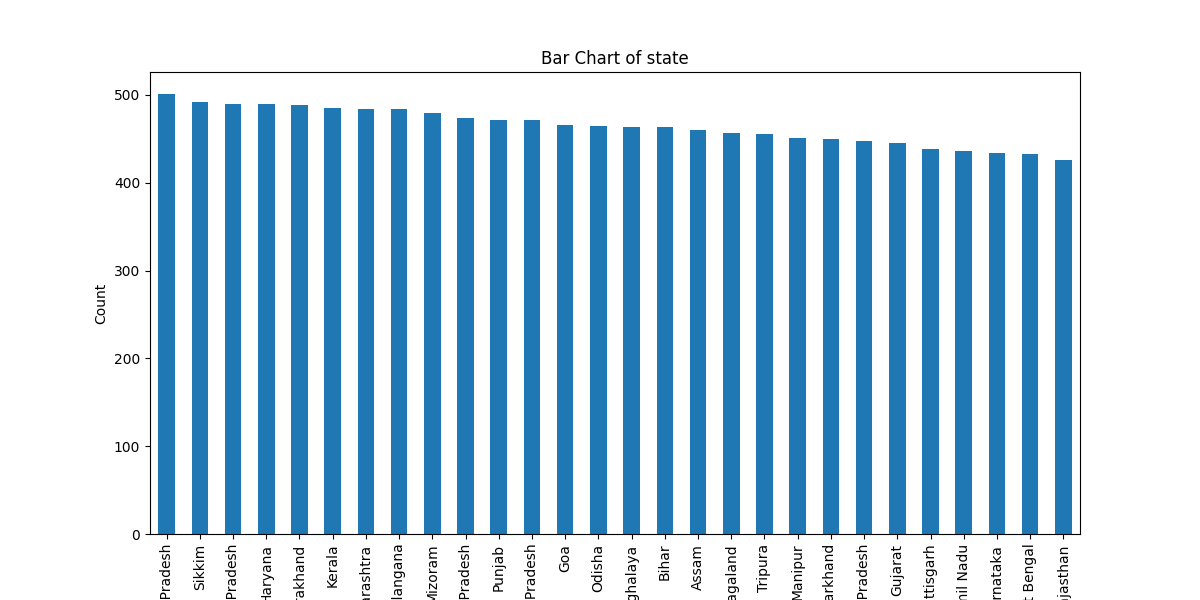

In [ ]:
#we run the code below to create a barchart for state variable
plot_barchart(data, 'state')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

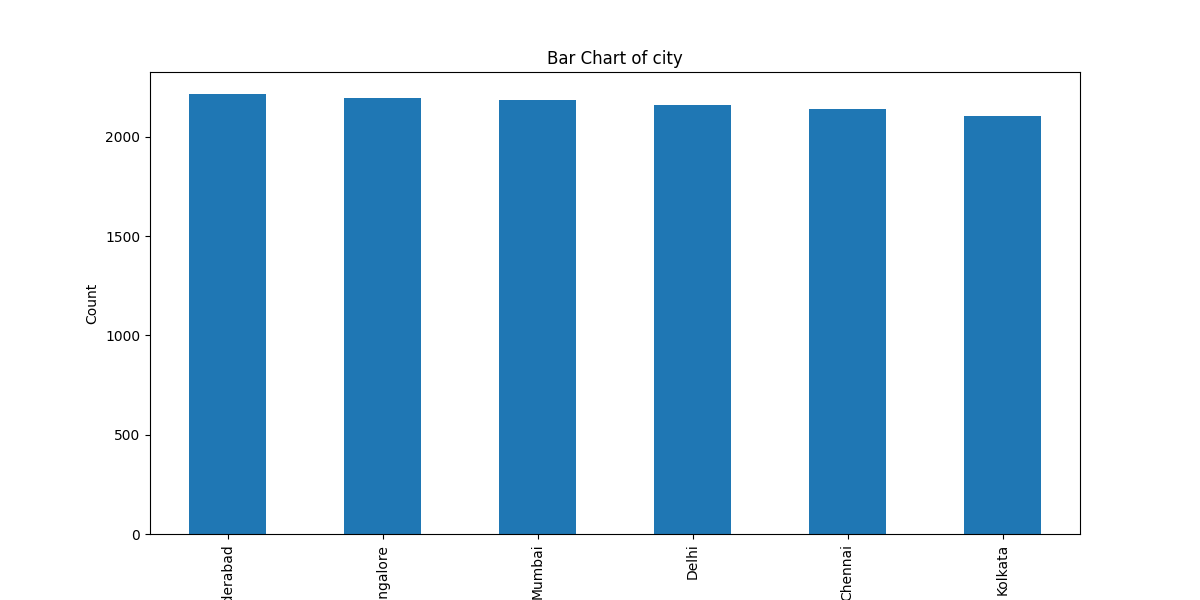

In [ ]:
#we run the code below to create a barchart for city variable
plot_barchart(data, 'city')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

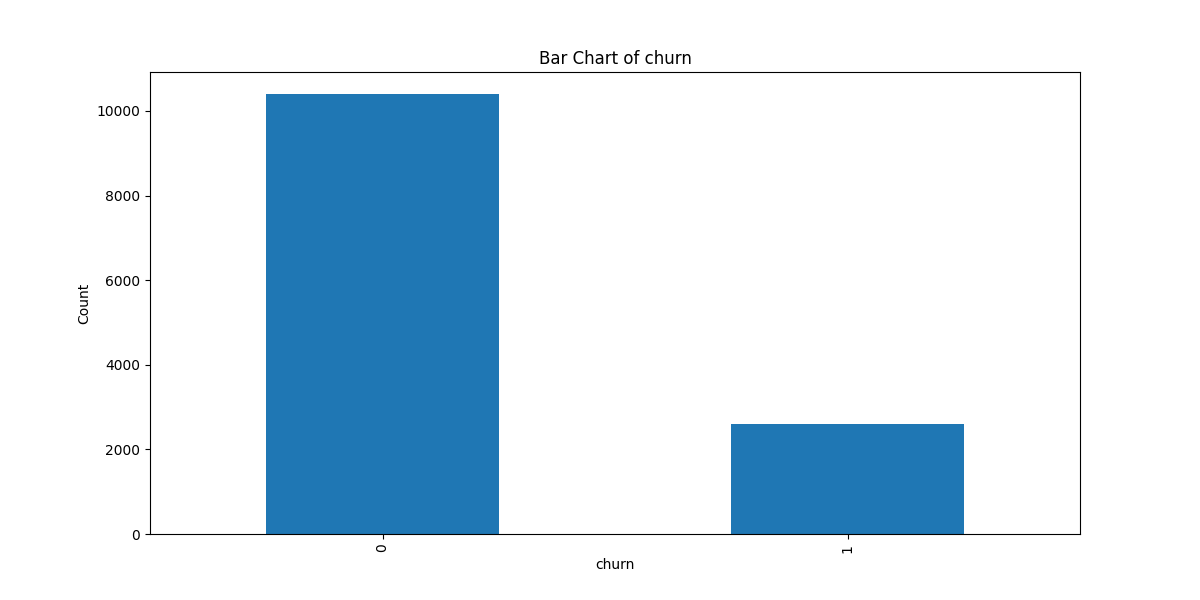

In [ ]:
##we run the code below to create a barchart for churn variable
plot_barchart(data, 'churn')
%matplot plt

The barchart above shows a larger proportion of customers churned than did not

## Outliers
Next, we check and solve for outliers below following the process below

In [ ]:
#we run the code below to intitialize a spark dataframe
data = data.to_spark()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1690843046081_0006/container_1690843046081_0006_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [ ]:
from pyspark.sql import SparkSession

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
spark = SparkSession.builder.getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
from pyspark.sql.functions import col, stddev, avg, abs

def identify_outliers(dataset, columns, threshold):
    spark = SparkSession.builder.getOrCreate()
    outliers = {}

    for column in columns:
        # Compute the mean and standard deviation for the column
        mean_stddev = dataset.select(avg(col(column)).alias('mean'), stddev(col(column)).alias('stddev')).first()

        # Calculate the z-scores for the column
        dataset = dataset.withColumn(column + "_zscore", (col(column) - mean_stddev['mean']) / mean_stddev['stddev'])

        # Identify outliers based on the threshold
        column_outliers = dataset.filter(abs(col(column + "_zscore")) > threshold)

        # Store outliers in the dictionary
        outliers[column] = column_outliers

        # Print the column name and its corresponding outliers
        print("Outliers for column '{}':".format(column))
        column_outliers.show()

    return outliers

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Assuming sparkSession and 'data' is PySpark DataFrame
columns = ['age', 'num_dependents', 'estimated_salary', 'calls_made', 'sms_sent', 'data_used']
threshold = 3

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Call the function to identify outliers for the specified columns
identified_outliers = identify_outliers(data, columns, threshold)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Outliers for column 'age':
+-----------+---------------+------+---+-----+----+-------+--------------------+--------------+----------------+----------+--------+---------+-----+----------+
|customer_id|telecom_partner|gender|age|state|city|pincode|date_of_registration|num_dependents|estimated_salary|calls_made|sms_sent|data_used|churn|age_zscore|
+-----------+---------------+------+---+-----+----+-------+--------------------+--------------+----------------+----------+--------+---------+-----+----------+
+-----------+---------------+------+---+-----+----+-------+--------------------+--------------+----------------+----------+--------+---------+-----+----------+

Outliers for column 'num_dependents':
+-----------+---------------+------+---+-----+----+-------+--------------------+--------------+----------------+----------+--------+---------+-----+----------+---------------------+
|customer_id|telecom_partner|gender|age|state|city|pincode|date_of_registration|num_dependents|estimated_salary|


After having implemented the z-score threshold for the removal of outliers, the output returns no outliers based based on the threshold used. However, informed by domain knowledge, we believe that negative values do not fit in the context of some of the variables such as "calls_made", "data_used", "sms-sent", hence we undertake their removal in the next steps below:

### Negative Values removal

In [ ]:
data = data[data.calls_made > 0]
data = data[data.data_used > 0]
data = data[data.sms_sent>0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#We run the code below to remove observations with data_used less than 500 MB
no_outliers = data[data.data_used > 500]
no_outliers.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+---------------+------+---+--------------+---------+-------+--------------------+--------------+----------------+----------+--------+---------+-----+
|customer_id|telecom_partner|gender|age|         state|     city|pincode|date_of_registration|num_dependents|estimated_salary|calls_made|sms_sent|data_used|churn|
+-----------+---------------+------+---+--------------+---------+-------+--------------------+--------------+----------------+----------+--------+---------+-----+
|     241859|       Vodafone|     M| 58|       Manipur|Bangalore| 500407| 2023-04-25 00:00:00|             2|           41014|        61|      45|     9961|    1|
|      17876|         Airtel|     M| 59|       Mizoram|   Mumbai| 507230| 2020-03-30 00:00:00|             0|           92175|        92|      12|     1140|    0|
|     200647|           BSNL|     M| 28|         Bihar|   Mumbai| 384932| 2022-10-01 00:00:00|             1|          149241|        22|      28|     5135|    0|
|     129137|         

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
def plot_hist(data, features, n_rows, n_cols):
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,10))
    fig.tight_layout(pad=5.0)

    for i, feature in enumerate(features):
        # Collect column data to driver node
        column_data = data.select(feature).rdd.flatMap(lambda x: x).collect()

        # Plot histogram on the appropriate subplot
        ax[i//n_cols, i%n_cols].hist(column_data, bins=30, edgecolor='black')
        ax[i//n_cols, i%n_cols].set_title(feature)

    plt.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
features = ['estimated_salary', 'calls_made', 'data_used', 'sms_sent']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

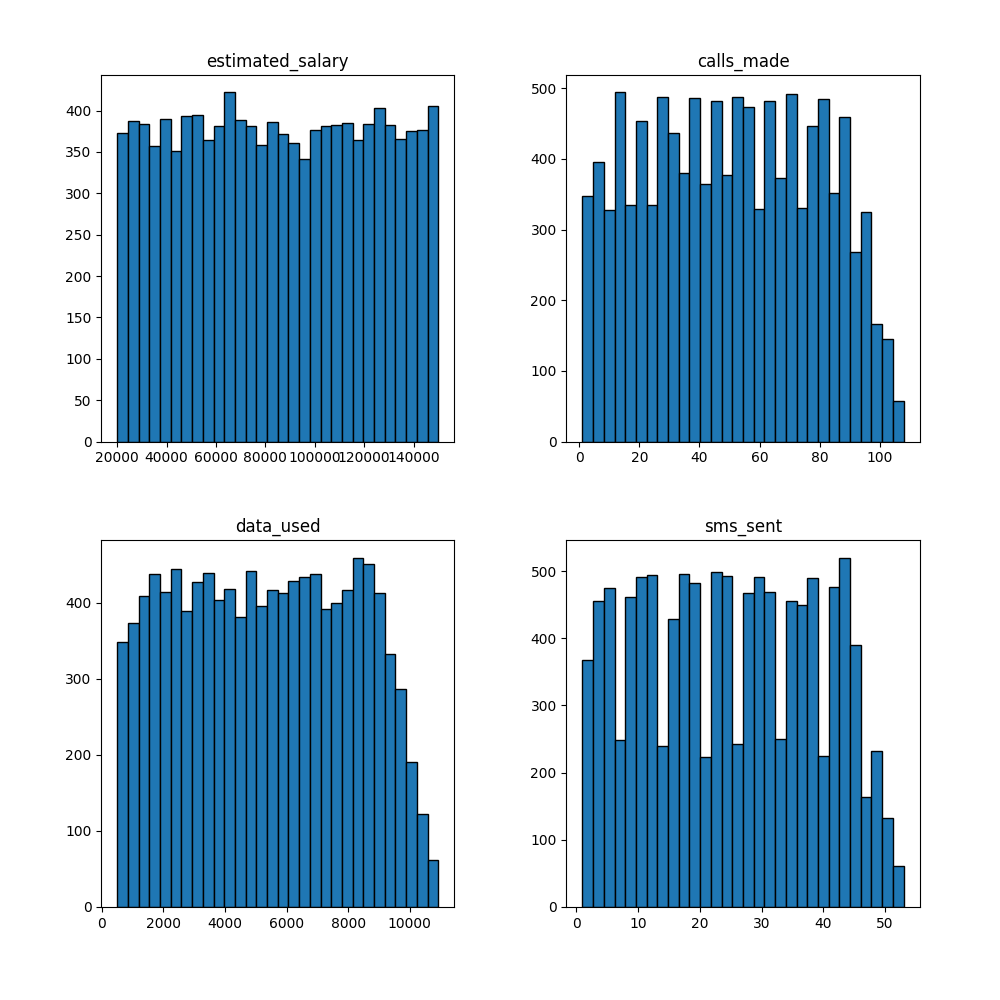

In [ ]:
#we run the code the below to plot the histograms after removing the outlier-
plot_hist(data=no_outliers, features=features, n_rows=2, n_cols=2)
%matplot plt

Regardless we observe that the distribution of the histograms is not any significantly impacted, leading us to conclude that the outlying values have no effect on the overall distribution of the dataset.

# Milestone III Implementation Starts Here

### Correlation Analysis

We perform correlation analysis on the numerical variables to assess the strength and direction of their linear relationship. We run the code below to implement this

In [ ]:
from pyspark.sql.functions import corr

numerical_features = ['age', 'num_dependents', 'estimated_salary', 'calls_made', 'sms_sent', 'data_used']

for i in range(0, len(numerical_features)):
    for j in range(i+1, len(numerical_features)):
        correlation_value = data.stat.corr(numerical_features[i], numerical_features[j])
        print(f"Correlation between {numerical_features[i]} and {numerical_features[j]}: {correlation_value}")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Correlation between age and num_dependents: 0.00033377694149931426
Correlation between age and estimated_salary: -0.019354468901486798
Correlation between age and calls_made: -0.007201311915704921
Correlation between age and sms_sent: 0.0020869709447342293
Correlation between age and data_used: 0.011210998618513884
Correlation between num_dependents and estimated_salary: -0.0073430168523218285
Correlation between num_dependents and calls_made: -0.003129220140796443
Correlation between num_dependents and sms_sent: 0.014736442509158287
Correlation between num_dependents and data_used: -0.008198120363605038
Correlation between estimated_salary and calls_made: -0.011571930979899123
Correlation between estimated_salary and sms_sent: 0.003144196870527887
Correlation between estimated_salary and data_used: -0.024425561824776412
Correlation between calls_made and sms_sent: 0.00990435339856176
Correlation between calls_made and data_used: 0.004751531107597839
Correlation between sms_sent and da

Following this general guide to correlation interpretation:
- Close to +1: A strong positive relationship
- Close to -1: A strong negative relationship
- Close to 0: No or a very weak relationship

In general, these correlations are very weak positive and negative relationships, suggesting that there is little linear relationship between these pairs of variables. However, there could still be non-linear relationships, or relationships involving more than two variables, which aren't captured by these simple pairwise correlations.

**Initializing the next phase**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, ChiSqSelector
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# create Spark session
spark = SparkSession.builder.appName("telecom_churn_prediction").getOrCreate()

# load the data
data = spark.read.csv('s3://jiogboles3private/spark/new_telcom_churn.csv', inferSchema=True, header=True)

# show the first few records
data.show(5)


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1691077729082_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+---------------+------+---+-------------+---------+-------+--------------------+--------------+----------------+----------+--------+---------+-----+
|customer_id|telecom_partner|gender|age|        state|     city|pincode|date_of_registration|num_dependents|estimated_salary|calls_made|sms_sent|data_used|churn|
+-----------+---------------+------+---+-------------+---------+-------+--------------------+--------------+----------------+----------+--------+---------+-----+
|     241859|       Vodafone|     M| 58|      Manipur|Bangalore| 500407| 2023-04-25 00:00:00|             2|           41014|        61|      45|     9961|    1|
|      17876|         Airtel|     M| 59|      Mizoram|   Mumbai| 507230| 2020-03-30 00:00:00|             0|           92175|        92|      12|     1140|    0|
|      38273|           BSNL|     M| 40|        Bihar|  Chennai| 453495| 2020-07-10 00:00:00|             2|          109436|        82|      19|     -604|    0|
|     200647|           BSNL

As always, it is crucial to check the dataset for missing/null/NA values. we do this below

In [ ]:
#We run the following code to check if there are any empty or null values in the dataset
from pyspark.sql.functions import col, sum as sql_sum

# Checking for null or NA values
data.select(*(sql_sum(col(c).isNull().cast('int')).alias(c) for c in data.columns)).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+---------------+------+---+-----+----+-------+--------------------+--------------+----------------+----------+--------+---------+-----+
|customer_id|telecom_partner|gender|age|state|city|pincode|date_of_registration|num_dependents|estimated_salary|calls_made|sms_sent|data_used|churn|
+-----------+---------------+------+---+-----+----+-------+--------------------+--------------+----------------+----------+--------+---------+-----+
|          0|              0|     0|  0|    0|   0|      0|                   0|             0|               0|         0|       0|        0|    0|
+-----------+---------------+------+---+-----+----+-------+--------------------+--------------+----------------+----------+--------+---------+-----+

**Data Transformation**

We begin the process below. first we drop columns that are irrelevant to the analysis and modeling

In [ ]:
#drop columns not needed
data = data.drop('customer_id', 'date_of_registration')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#print dataframe to confirm dropped columns
data.show(2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------+---+-------+---------+-------+--------------+----------------+----------+--------+---------+-----+
|telecom_partner|gender|age|  state|     city|pincode|num_dependents|estimated_salary|calls_made|sms_sent|data_used|churn|
+---------------+------+---+-------+---------+-------+--------------+----------------+----------+--------+---------+-----+
|       Vodafone|     M| 58|Manipur|Bangalore| 500407|             2|           41014|        61|      45|     9961|    1|
|         Airtel|     M| 59|Mizoram|   Mumbai| 507230|             0|           92175|        92|      12|     1140|    0|
+---------------+------+---+-------+---------+-------+--------------+----------------+----------+--------+---------+-----+
only showing top 2 rows

**Data Partitioning**

Next we split the dataset into test and train sets for the purpose of model evaluation, overfitting detection, hyperparameter tuning and prevention of data leakage.

In [ ]:
#split data into train and test sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In the code above, randomSplit function is used to randomly split the data into training and test sets. The argument [0.7, 0.3] means that approximately 70% of the data will be used for model training and 30% as our test dataset

In [ ]:
#get a count of train set
train_data.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

9198

In [ ]:
#get a count of test set
test_data.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3802

In [ ]:
#print train dataframe
train_data.show(2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------+---+-----------------+---------+-------+--------------+----------------+----------+--------+---------+-----+
|telecom_partner|gender|age|            state|     city|pincode|num_dependents|estimated_salary|calls_made|sms_sent|data_used|churn|
+---------------+------+---+-----------------+---------+-------+--------------+----------------+----------+--------+---------+-----+
|         Airtel|     F| 18|Arunachal Pradesh|Hyderabad| 663657|             3|          140043|         8|      -2|     5154|    0|
|         Airtel|     F| 18|Arunachal Pradesh|  Kolkata| 403882|             0|           87551|        67|      22|     3919|    1|
+---------------+------+---+-----------------+---------+-------+--------------+----------------+----------+--------+---------+-----+
only showing top 2 rows

In [ ]:
#print test dataframe
test_data.show(2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------+---+---------+-------+-------+--------------+----------------+----------+--------+---------+-----+
|telecom_partner|gender|age|    state|   city|pincode|num_dependents|estimated_salary|calls_made|sms_sent|data_used|churn|
+---------------+------+---+---------+-------+-------+--------------+----------------+----------+--------+---------+-----+
|         Airtel|     F| 18|    Assam|Chennai| 786664|             4|          122587|        71|      36|     7230|    0|
|         Airtel|     F| 18|Rajasthan| Mumbai| 545310|             3|          145860|        99|      16|     5723|    1|
+---------------+------+---+---------+-------+-------+--------------+----------------+----------+--------+---------+-----+
only showing top 2 rows

**Normalization and Dummy Variables Creation ~ Modeling Pipeline Construction**

Below we normalize the numerical variables to adjust our input features to a common scale without distorting the differences in range of values or losing information

Normalizing numerical features, such as 'estimated_salary', 'calls_made', 'sms_sent', and 'data_used', is essential as it brings all the values into a similar scale

For categorical variables like 'gender', 'state', 'city', etc. we create n-1 dummy variables to avoid the dummy variables trap.

In the code below, StringIndexer transforms each categorical column to a column of numerical indices, and OneHotEncoder maps a column of category indices to a column of binary vectors.

In PySpark's ML library, many functions (including the StandardScaler) require that the input data is assembled into a single column of vectors, not a DataFrame of scalar columns, we implement all of these in the cells that follow.

In [ ]:
# Apply StringIndexer to 'gender' column and display the result
indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
indexed = indexer.fit(data).transform(data)
indexed.select("gender", "gender_index").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+------------+
|gender|gender_index|
+------+------------+
|     M|         0.0|
|     M|         0.0|
|     M|         0.0|
|     M|         0.0|
|     F|         1.0|
|     M|         0.0|
|     M|         0.0|
|     M|         0.0|
|     F|         1.0|
|     F|         1.0|
|     F|         1.0|
|     M|         0.0|
|     M|         0.0|
|     M|         0.0|
|     M|         0.0|
|     M|         0.0|
|     M|         0.0|
|     M|         0.0|
|     M|         0.0|
|     F|         1.0|
+------+------------+
only showing top 20 rows

In the cell output above, we applied the stringindexer transformation to the gender column as test to ensure that our categorical tranformation is being correctly applied. The output is as expected. We also do the same for "state" and "city" categorical variables.

In [ ]:
# Apply StringIndexer to 'state' column and display the result
indexer = StringIndexer(inputCol="state", outputCol="state_index")
indexed = indexer.fit(data).transform(data)
indexed.select("state", "state_index").show()

# Apply StringIndexer to 'city' column and display the result
indexer = StringIndexer(inputCol="city", outputCol="city_index")
indexed = indexer.fit(data).transform(data)
indexed.select("city", "city_index").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----------+
|         state|state_index|
+--------------+-----------+
|       Manipur|       19.0|
|       Mizoram|        8.0|
|         Bihar|       14.0|
|         Bihar|       14.0|
| Uttar Pradesh|       11.0|
|      Nagaland|       17.0|
|   Maharashtra|        6.0|
|        Sikkim|        1.0|
|Andhra Pradesh|       21.0|
|       Manipur|       19.0|
|     Telangana|        7.0|
|           Goa|       12.0|
|    Tamil Nadu|       24.0|
|Andhra Pradesh|       21.0|
|Madhya Pradesh|        9.0|
|       Manipur|       19.0|
|        Sikkim|        1.0|
|       Mizoram|        8.0|
|     Telangana|        7.0|
|       Mizoram|        8.0|
+--------------+-----------+
only showing top 20 rows

+---------+----------+
|     city|city_index|
+---------+----------+
|Bangalore|       1.0|
|   Mumbai|       2.0|
|  Chennai|       4.0|
|   Mumbai|       2.0|
|    Delhi|       3.0|
|  Chennai|       4.0|
|    Delhi|       3.0|
|Hyderabad|       0.0|
|    Delhi|       3.0|
|H

The output above is as expected and confirms the stringindexers transformation is implementing as specified. Let's continue.

**Below** we implement the categorical transformation(dummy creation) on the dataframe as a whole

In [ ]:
# List of numerical columns
numerical_columns = ['age', 'num_dependents', 'estimated_salary', 'calls_made', 'sms_sent', 'data_used']

# List of categorical columns
categorical_columns = list(set(data.columns) - set(numerical_columns) - set(['churn']))

# StringIndexer for categorical columns (n-1 dummies)
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").setHandleInvalid("keep")
            for column in categorical_columns]

# Apply StringIndexer to all categorical columns
pipeline = Pipeline(stages=indexers)
data_indexed = pipeline.fit(data).transform(data)

# Display the DataFrame after StringIndexer
data_indexed.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------+---+--------------+---------+-------+--------------+----------------+----------+--------+---------+-----+-------------+------------+----------+-----------+---------------------+
|telecom_partner|gender|age|         state|     city|pincode|num_dependents|estimated_salary|calls_made|sms_sent|data_used|churn|pincode_index|gender_index|city_index|state_index|telecom_partner_index|
+---------------+------+---+--------------+---------+-------+--------------+----------------+----------+--------+---------+-----+-------------+------------+----------+-----------+---------------------+
|       Vodafone|     M| 58|       Manipur|Bangalore| 500407|             2|           41014|        61|      45|     9961|    1|       5891.0|         0.0|       1.0|       19.0|                  3.0|
|         Airtel|     M| 59|       Mizoram|   Mumbai| 507230|             0|           92175|        92|      12|     1140|    0|       6001.0|         0.0|       2.0|        8.0|             

The output is as specified and expected.Let's continue

**Next** we turn to the transformation(normalization) of the numerical variables as described in following order:

In [ ]:
# VectorAssembler for numerical columns
assemblerInputs = [c + "_index" for c in categorical_columns] + numerical_columns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Transform data using VectorAssembler
assembled_data = assembler.transform(data_indexed)

# Display the DataFrame after VectorAssembler
assembled_data.select("features").show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|            features|
+--------------------+
|[5891.0,0.0,1.0,1...|
|[6001.0,0.0,2.0,8...|
|[5214.0,0.0,4.0,1...|
|[4215.0,0.0,2.0,1...|
|[7957.0,1.0,3.0,1...|
|[10172.0,0.0,4.0,...|
|[8930.0,0.0,3.0,6...|
|[8743.0,0.0,0.0,1...|
|[4565.0,1.0,3.0,2...|
|[1179.0,1.0,0.0,1...|
+--------------------+
only showing top 10 rows

**The** output above confirms that the numerical transformation is correctly applied. We'll go ahead and normalize all assembled numerical vectors below

In [ ]:
# StandardScaler for normalization
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Transform data using StandardScaler
scaled_data = scaler.fit(assembled_data).transform(assembled_data)

# Display the DataFrame after StandardScaler
scaled_data.select("scaledFeatures").show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|      scaledFeatures|
+--------------------+
|[1.57032696625958...|
|[1.59964897717259...|
|[1.38986331727677...|
|[1.12356614543950...|
|[2.12104764395306...|
|[2.71148631824690...|
|[2.38041415866543...|
|[2.33056674011331...|
|[1.21686345289000...|
|[0.31427864424037...|
+--------------------+
only showing top 10 rows

The output above is as expected, let's continue

**Next** we implement the **logistic regression** **modeling, hyperparameter tuning** and make **predictions** on our test dataset

In [ ]:
# Logistic Regression model
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="churn")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Hyperparameter tuning
# Define the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.5, 2.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define the cross-validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='churn'),
                          numFolds=3)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(scaled_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-16:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [ ]:
# Make predictions on the test data
predictions = cvModel.transform(scaled_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-17:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [ ]:
# Show predictions
predictions.select("prediction", "churn").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-18:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



+----------+-----+
|prediction|churn|
+----------+-----+
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
+----------+-----+
only showing top 20 rows

**The output** above is as anticipated. To describe what has transpired above in the three cells above: This code performs hyperparameter tuning on the logistic regression model, using a grid of regParam and elasticNetParam values. It uses 3-fold cross-validation, and selects the model with the best AUC-ROC as measured by the BinaryClassificationEvaluator. The best model is then used to make predictions on the test data.

**Having applied**  the logistic regression model to make predictions on our test data, we proceed to calculate the model performance metrics as follows:

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Define the evaluators
binary_evaluator = BinaryClassificationEvaluator(labelCol='churn')
multi_evaluator = MulticlassClassificationEvaluator(labelCol='churn')

# Compute the evaluation metrics
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})
auc = binary_evaluator.evaluate(predictions)

# Print the evaluation metrics
print("Model Performance Summary:")
print("Accuracy = {:.2f}".format(accuracy))
print("Precision = {:.2f}".format(precision))
print("Recall = {:.2f}".format(recall))
print("F1 Score = {:.2f}".format(f1))
print("AUC = {:.2f}".format(auc))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-21:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



Model Performance Summary:
Accuracy = 0.80
Precision = 0.64
Recall = 0.80
F1 Score = 0.71
AUC = 0.50

**We interpret these numbers below**

- Accuracy (0.8): This means that 80% of the time, the model correctly predicted whether a customer churned or not.
- Precision (0.64): Precision is the proportion of true positive predictions (in this case, customers that churned and were correctly predicted as such) out of all positive predictions (all customers predicted to churn). So, of all the customers that the model predicted would churn, 64% of them actually did churn.
- Recall (0.8): Recall, or sensitivity, is the proportion of true positive predictions out of all actual positives (all customers who actually churned). So,the model correctly identified 80% of the customers who churned.
- F1 Score (0.71): The F1 Score is the harmonic mean of precision and recall. It's a single metric that combines both precision and recall. An F1 Score closer to 1 indicates a better balance between precision and recall. The F1 score is 0.71, which indicates a reasonably good balance.
- AUC (0.5): The Area Under the ROC Curve (AUC-ROC) is a measure of the model's ability to distinguish between positive and negative classes. An AUC of 0.5 indicates that the model has no discrimination capacity to distinguish between positive and negative classes.


It seems like the model has good accuracy, recall, and a reasonable F1 score, but the AUC is quite low. The low AUC might be a result of the class imbalance in the data, poor predictive power of the features, or it might need further tuning of hyperparameters or more advanced feature engineering.


**Below we attempt to print the intercepts and coefficients of the models' predictor variables**

In [ ]:
# Get the best Logistic Regression model
bestModel = cvModel.bestModel

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(bestModel.coefficients))
print("Intercept: " + str(bestModel.intercept))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Coefficients: (11,[],[])
Intercept: -1.3862943611198906

Exception in thread cell_monitor-22:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [ ]:
# Get the best Logistic Regression model
bestModel = cvModel.bestModel

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(bestModel.coefficients))
print("Intercept: " + str(bestModel.intercept))

# Obtain the receiver-operating characteristic as a DataFrame and areaUnderROC.
trainingSummary = bestModel.summary
print("ROC: Area Under Curve (AUC) = " + str(trainingSummary.areaUnderROC))

# Get the model coefficients
coefficients = bestModel.coefficients

# Map feature names to coefficients
feature_names = assemblerInputs
feature_coefficients = list(zip(feature_names, coefficients))

for feature in feature_coefficients:
    print(feature)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-23:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



Coefficients: (11,[],[])
Intercept: -1.3862943611198906
ROC: Area Under Curve (AUC) = 0.5
('pincode_index', 0.0)
('gender_index', 0.0)
('city_index', 0.0)
('state_index', 0.0)
('telecom_partner_index', 0.0)
('age', 0.0)
('num_dependents', 0.0)
('estimated_salary', 0.0)
('calls_made', 0.0)
('sms_sent', 0.0)
('data_used', 0.0)

**If you observe closely you'll notice something unusual.**

The output suggests that all the coefficients for the independent variables in the logistic regression model are 0. This is unusual and implies that, according to the model, none of the features have any influence on the target variable 'churn'.


**We believe** this is because the regularization parameter is set too high. When this is the case, it could push all coefficients towards zero.

**So** we adjust the values of the regularization parameter (regParam) in the model and rerun the model to see if there is any difference in outcome.

In [ ]:
# Logistic Regression model
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="churn")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-25:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [ ]:
# Define the parameter grid
# Tune hyperparameter. notice the parameter as much lower than before
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.01, 0.1, 1.0, 10.0]) \
    .addGrid(lr.elasticNetParam, [0.0]) \
    .build()

# Define the cross-validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='churn'),
                          numFolds=3)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(scaled_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-26:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [ ]:
# Make predictions on the test data
predictions = cvModel.transform(scaled_data)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-27:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [ ]:
# Show predictions
predictions.select("prediction", "churn").show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-28:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



+----------+-----+
|prediction|churn|
+----------+-----+
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
+----------+-----+
only showing top 20 rows

**Below we print the coefficients as we did earlier to see if they are any different than zero**

In [ ]:
# Get the best Logistic Regression model
bestModel = cvModel.bestModel

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(bestModel.coefficients))
print("Intercept: " + str(bestModel.intercept))

# Obtain the receiver-operating characteristic as a DataFrame and areaUnderROC.
trainingSummary = bestModel.summary
print("ROC: Area Under Curve (AUC) = " + str(trainingSummary.areaUnderROC))

# Get the model coefficients
coefficients = bestModel.coefficients

# Map feature names to coefficients
feature_names = assemblerInputs
feature_coefficients = list(zip(feature_names, coefficients))

for feature in feature_coefficients:
    print(feature)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-30:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



Coefficients: [-0.005766840139288066,-0.011607216809631143,0.028847941732903025,0.02969447799298724,0.03802321179498868,-0.016963496208451955,-0.010127339613500501,0.008093214541628304,0.004007294767260409,-0.04502621461426905,-0.02256252550701667]
Intercept: -1.3610341860912762
ROC: Area Under Curve (AUC) = 0.5218774038461532
('pincode_index', -0.005766840139288066)
('gender_index', -0.011607216809631143)
('city_index', 0.028847941732903025)
('state_index', 0.02969447799298724)
('telecom_partner_index', 0.03802321179498868)
('age', -0.016963496208451955)
('num_dependents', -0.010127339613500501)
('estimated_salary', 0.008093214541628304)
('calls_made', 0.004007294767260409)
('sms_sent', -0.04502621461426905)
('data_used', -0.02256252550701667)

**As you can see the coefficients are now more reasonable than the first iteration** It appears the hyperparameters was set too high in the first instance.

**To provide** some more context:

The regParam is a regularization parameter. Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function. If regParam is too large, it may result in underfitting, which might push all coefficients towards zero.

On the other hand, elasticNetParam corresponds to the Elastic Net mixing parameter. If elasticNetParam = 0, the trained model will be L2 regularization (Ridge). If elasticNetParam = 1, it will be L1 regularization (Lasso).

What we did was use a wider range of regParam values and fix elasticNetParam to 0 (which means we're using L2 or Ridge regularization)

**With respect to interpretation**

- The intercept (−1.3610341860912762) is the log-odds of the 'churn' event when all the independent variables are held at zero. In the context of your logistic regression model, it's not very interpretable because the independent variables can't all be zero at the same time (for example, 'age' can't be zero).

- 'pincode_index' ( − 0.005766840139288066): For each one-unit increase in 'pincode_index', the log-odds of 'churn' decreases by approximately 0.00577, given all other variables are held constant.
- 'gender_index' (−0.011607216809631143): For each one-unit increase in 'gender_index', the log-odds of 'churn' decreases by approximately 0.0116, given all other variables are held constant.
- 'city_index' (0.028847941732903025): For each one-unit increase in 'city_index', the log-odds of 'churn' increases by approximately 0.02885, given all other variables are held constant.
- 'state_index' (0.02969447799298724): For each one-unit increase in 'state_index', the log-odds of 'churn' increases by approximately 0.02969, given all other variables are held constant.
And so on...

It is important to note that the coefficients are based on the scaled features. Therefore, a one-unit change is in terms of the standardized values, not the original scale of the variables.



- **The AUC-ROC (0.5218774038461532) is a measure of the overall performance of the model. It ranges from 0.5 to 1, where 0.5 indicates a model that performs no better than random guessing, and 1 indicates a model that performs perfectly. An AUC-ROC of approximately 0.52 suggests that the model's performance is slightly better than random guessing, but there's certainly room for improvement.**

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Define the evaluators
binary_evaluator = BinaryClassificationEvaluator(labelCol='churn')
multi_evaluator = MulticlassClassificationEvaluator(labelCol='churn')

# Compute the evaluation metrics
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})
auc = binary_evaluator.evaluate(predictions)

# Print the evaluation metrics
print("Model Performance Summary:")
print("Accuracy = {:.2f}".format(accuracy))
print("Precision = {:.2f}".format(precision))
print("Recall = {:.2f}".format(recall))
print("F1 Score = {:.2f}".format(f1))
print("AUC = {:.2f}".format(auc))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model Performance Summary:
Accuracy = 0.80
Precision = 0.64
Recall = 0.80
F1 Score = 0.71
AUC = 0.52

**We print the model performance metrics above. As you can see they are not any different than in the first instance. plus the interpretation is similar as before**

**Below we print the objective history**

The objective history represents the value of the objective function (the function being minimized during the optimization process) at each iteration of the model's training process. The values you see are the objective function values at each step of the training process.

In [ ]:
# Extract the summary from the LogisticRegressionModel instance trained
trainingSummary = cvModel.bestModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("ObjectiveHistory:")
for objective in objectiveHistory:
    print(objective)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ObjectiveHistory:
0.5004024235381358
0.499929761068848
0.49989544698134775
0.49989542872084336
0.49989542870625786

Exception in thread cell_monitor-32:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



**Ideally**, we would like to see these values decrease with each iteration, which would indicate that the model is learning and improving. In this case, the values are indeed decreasing, which is a good sign.

The fact that the values stop decreasing after the fourth iteration might indicate that the model has reached a point where it cannot improve further given the current data and hyperparameters. This could be due to the model reaching its capacity to learn from the given features, or due to the data not containing enough information to further reduce the objective function.

## Random Forest Implementation

**As directed** we implement the **Random forest model** as well and proceed to calculate the model performance metrics and make comparisons with the **Logistic Regression model.** This will enable us compare these two models and recommend which is more effective given the dataset and context of the analysis.

In [ ]:
#we initialize the process by provisionin required packages and libraries
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-33:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



**Next** we implement the **Random Forest** **modeling, hyperparameter tuning** and make **predictions** on our test dataset

In [ ]:
# Define the Random Forest model
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="churn")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-34:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [ ]:
# Define the parameter grid for hyperparameter tuning
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.maxBins, [32, 64, 128]) \
    .build()

# Define the cross-validation
crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=BinaryClassificationEvaluator(labelCol='churn'),
                             numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-35:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [ ]:
# Run cross-validation, and choose the best set of parameters.
cvModel_rf = crossval_rf.fit(scaled_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-36:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [ ]:
# Make predictions on the test data
predictions_rf = cvModel_rf.transform(scaled_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Show predictions
predictions_rf.select("prediction", "churn").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|prediction|churn|
+----------+-----+
|       1.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
+----------+-----+
only showing top 20 rows

The output above is as expected.

**Random Forest Model Performance Evaluation Metrics**

Below we calculate the performance metrics for the random forest model.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize the MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="churn")

# Compute the classification error on test data.
accuracy = evaluator.evaluate(predictions_rf, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions_rf, {evaluator.metricName: "f1"})

# Binary classification evaluator
evaluator_binary = BinaryClassificationEvaluator(labelCol="churn")
auc = evaluator_binary.evaluate(predictions_rf, {evaluator_binary.metricName: "areaUnderROC"})

print("Model Performance Summary")
print("Accuracy = %g" % accuracy)
print("Precision = %g" % precision)
print("Recall = %g" % recall)
print("F1 Score = %g" % f1)
print("AUC = %g" % auc)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model Performance Summary
Accuracy = 0.904308
Precision = 0.914253
Recall = 0.904308
F1 Score = 0.892045
AUC = 0.989055

- Accuracy (0.904308): This is the proportion of total predictions that were correct. So, about 90.43% of the time, the model is predicting whether a customer churns correctly.

- Precision (0.914253): Precision answers the question "what proportion of positive identifications were actually correct?" A precision score of 0.914 means that when the model predicts customer churn, it is correct about 91.43% of the time.

- Recall (0.904308): Recall answers the question "what proportion of actual positives was identified correctly?" So, the model correctly identifies 90.43% of all actual customer churns.

- F1 Score (0.892045): The F1 score is a harmonic mean of precision and recall. An F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. In this case, an F1 score of 0.892 suggests that the model has fairly high precision and recall.

- AUC (0.989055): AUC stands for "Area under the ROC Curve." An AUC score of 1 indicates perfect classifier performance, while an AUC score of 0.5 indicates a model that is as good as random. An AUC of approximately 0.989 suggests that the model does an excellent job distinguishing between customers who churn and those who don't

The feature Importances attribute of the trained RandomForestClassifier model gives the importance of each feature in predicting the target variable. This can be useful for understanding which features the model considers most informative. We proceed to extract this key component below:

In [ ]:
# Get the feature importances
importances = cvModel_rf.bestModel.featureImportances

# Map feature names to importances
feature_importances = list(zip(assemblerInputs, importances))

for feature in feature_importances:
    print(feature)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

('pincode_index', 0.14294714425806412)
('gender_index', 0.023270155269575758)
('city_index', 0.056293380275098795)
('state_index', 0.0956011433751396)
('telecom_partner_index', 0.04746933925398193)
('age', 0.11924668501717675)
('num_dependents', 0.054331782880906475)
('estimated_salary', 0.11578005955582733)
('calls_made', 0.11639221636724442)
('sms_sent', 0.11124689650985864)
('data_used', 0.11742119723712621)

**In terms of interpretation** **~ technical and managerial insights**

The feature importance values represent the relative contribution of each feature to the prediction model. Specifically, these values indicate how important each feature is in making accurate predictions of the target variable. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature.

Looking at the output printed above:

- The 'pincode_index' has the highest feature importance score (0.1429), indicating that it is the most influential variable in predicting customer churn in the Random Forest model. This might suggest that customers from certain areas (represented by pin codes) are more likely to churn than others.
- The 'data_used' (0.1174), 'calls_made' (0.1164), 'estimated_salary' (0.1158), and 'age' (0.1192) also have relatively high importance, suggesting that these factors significantly influence the churn prediction.
- 'gender_index' (0.0233) has the lowest feature importance, indicating it has the least influence on predicting customer churn in the model.

It is important to keep in mind that correlation does not equal causation ~ feature importance in this case doesn't imply causality—it just means those are the features that the model found most useful for making accurate predictions, based on the patterns it found in the training data. Also, while pincode, for instance, is an important feature, it doesn't necessarily mean that changing pincode will change churn. It's more likely that pincode is associated with other factors (like different marketing campaigns, regional trends, etc.) that influence churn.


**IN SUMMARY**


From a technical point of view, the random forest model appears to have higher prediction performance in comparision to the logistic regression model. Of course this is based on the dataset used in this analysis.

From our random forest features' importance scores, it apears that a number of variables features (outlined above) are worthy of further investigation as their scores/estimates suggest they play an important role in churn prediction.

By and large, a certain threshold and balance of domain knowledge and technical experience hold significance relevance to making sense of the numbers estimates from this research.  

Nonetheless, If we had to make a recommendation to the technical and managerial team of our client's organization, we would likely recomend the Random Forest model for extensive further and rigorous evaluation and analysis after which it can then be adopted and deployed at a production level.